# Temperature, Salinity, and Stratification #

In [9]:
import xray
from matplotlib import pyplot as plt
import seaborn
import numpy as np
import gsw
seaborn.set()
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,7)

In [5]:
# masks
woa_mask = xray.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/'
                             '.Masks/.basin/dods/').rename({'X':'lon', 'Y':'lat', 'Z': 'depth'})
basin_names = woa_mask.basin.attrs['CLIST'].split('\n')
basins_main = { n: basin_names[n-1] for n in [1,2,3,10] }
basins_marginal = { n: basin_names[n-1] for n in [4,5,6,7,11] }

In [6]:
woa = xray.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/'
                        '.Grid-1x1/.Annual/dods')
woa = woa.merge(woa_mask)

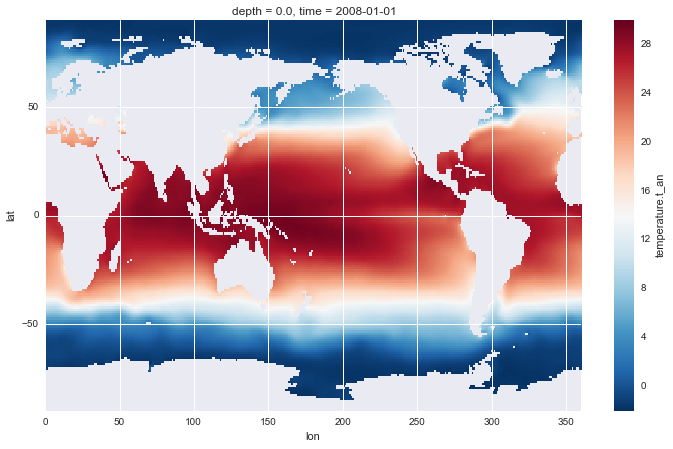

In [7]:
woa['temperature.t_an'][0,0].plot(yincrease=True, vmax=30, center=14)

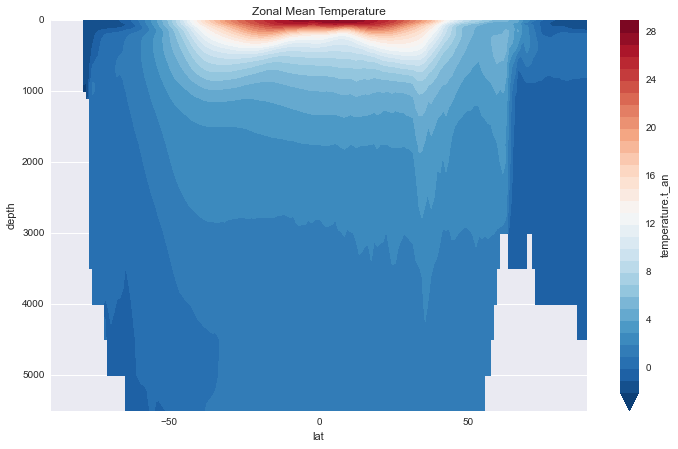

In [10]:
fig, ax = plt.subplots()
woa['temperature.t_an'][0].mean(dim='lon').plot.contourf(
    yincrease=False, vmax=30, center=14, levels=np.arange(-2,30))
ax.set_title('Zonal Mean Temperature')

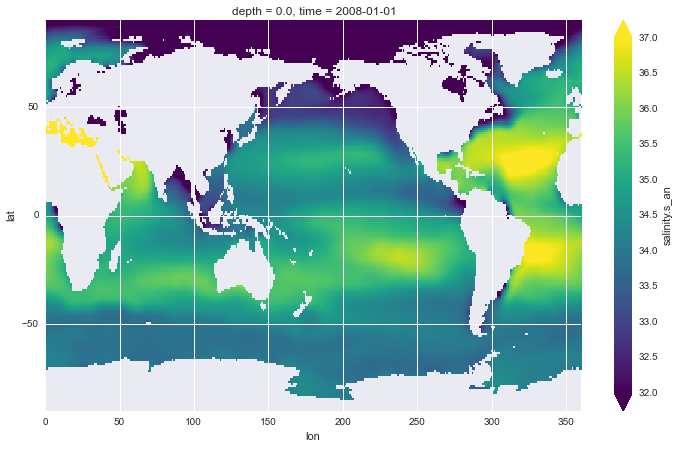

In [11]:
woa['salinity.s_an'][0,0].plot(yincrease=True, vmax=37, vmin=32)

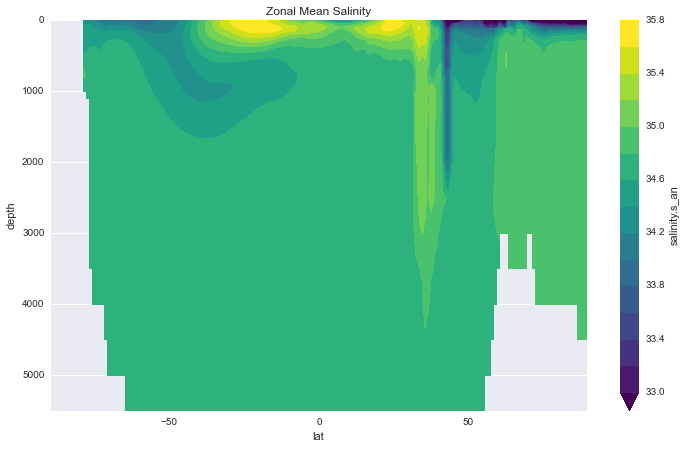

In [12]:
fig, ax = plt.subplots()
woa['salinity.s_an'][0].mean(dim='lon').plot.contourf(
    yincrease=False, levels=np.arange(33,36,0.2))
ax.set_title('Zonal Mean Salinity')

In [42]:
woa['thick'] = woa.depth.diff(dim='depth')
# add an area element
woa['area'] = (gsw.earth.earth_radius**2 *
               np.radians(1.) * np.radians(1.) *
               np.cos(np.radians(woa.lat)))
t, s, dz, a, basin = xray.broadcast_arrays(
                *xray.align(
                    woa['temperature.t_an'], woa['salinity.s_an'],
                    woa['thick'], woa['area'], woa['basin']
                )
              )
vol = dz*a

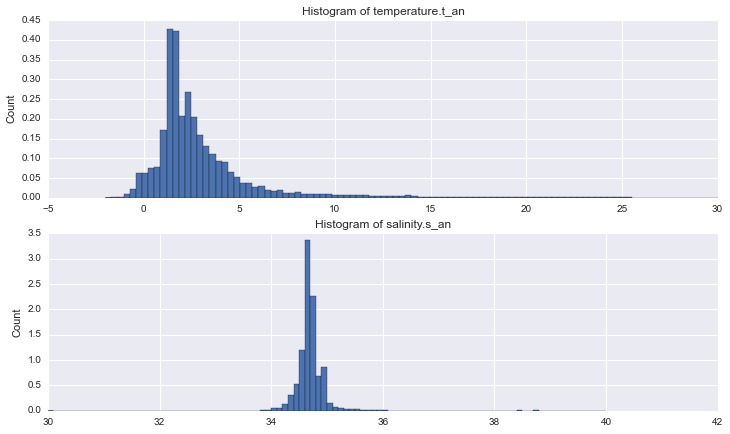

In [43]:
fig, (ax1, ax2) = plt.subplots(2)

# uncomment to make log scale
#[ax.set_yscale('log') for ax in [ax1, ax2]]

t.plot.hist(bins=100, ax=ax1,
            normed=True, range=(-2,30),
            weights=np.ma.masked_invalid(vol.where(~np.isnan(t)).values).compressed());

s.plot.hist(bins=100, ax=ax2,
            normed=True, range=(30,40),
            weights=np.ma.masked_invalid(vol.where(~np.isnan(s)).values).compressed());

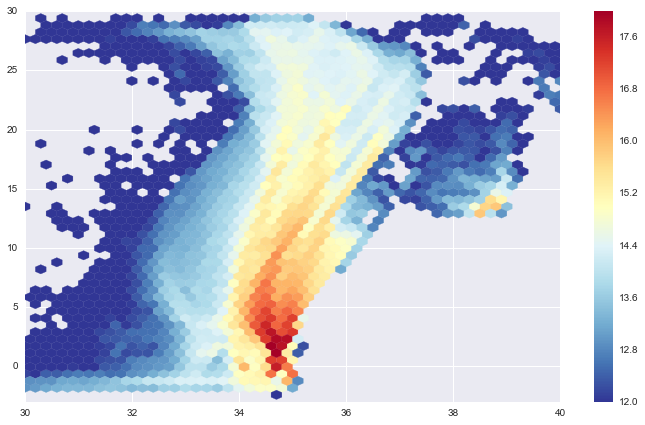

In [44]:
from matplotlib.colors import LogNorm
plt.hexbin(s.values.ravel(), t.values.ravel(),
           C=vol.values.ravel(), reduce_C_function=np.sum,
           extent=(30,40,-3,30), gridsize=50, bins='log',
           cmap='RdYlBu_r')
plt.colorbar()
plt.clim([12,18])

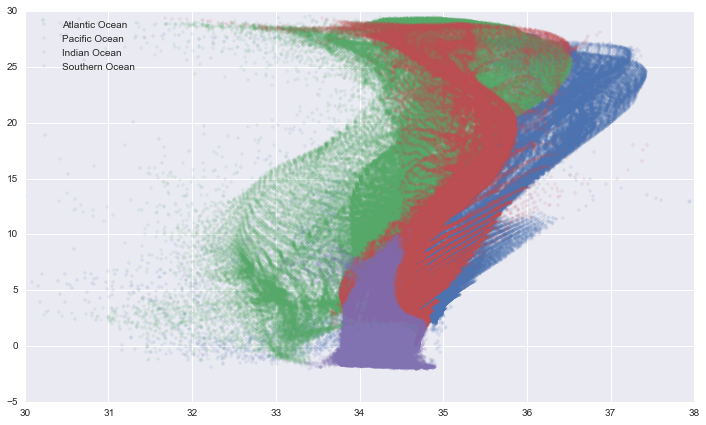

In [47]:
pal = seaborn.palettes.color_palette(n_colors=len(basins_main))
for (bnum, bname), col in zip(basins_main.iteritems(), pal):
    plt.plot(s.where(basin==bnum).values.ravel(), t.where(basin==bnum).values.ravel(),
             '.', color=col,
                alpha=0.1, label=bname
               )
plt.xlim(30,38)
plt.legend(loc='upper left')



In [48]:
# the goods are here
# https://www.nodc.noaa.gov/OC5/3M_HEAT_CONTENT/
# http://data.nodc.noaa.gov/thredds/catalog/woa/heat_content/heat_content/catalog.html
hc = xray.open_dataset('http://data.nodc.noaa.gov/thredds/dodsC/woa/'
                       'heat_content/heat_content/heat_content_anomaly_0-700_pentad.nc',
                        decode_times=False)
# fix time to something xray likes
hc.time *= (365/12.)
tunits = hc.time.attrs['units'].replace('months', 'days')
hc.time.attrs['units'] = tunits
hc = xray.decode_cf(hc)

/Users/rpa/tmp/xray/xray/conventions.py:775: UserWarning: CF decoding is overwriting dtype
  warnings.warn("CF decoding is overwriting dtype")


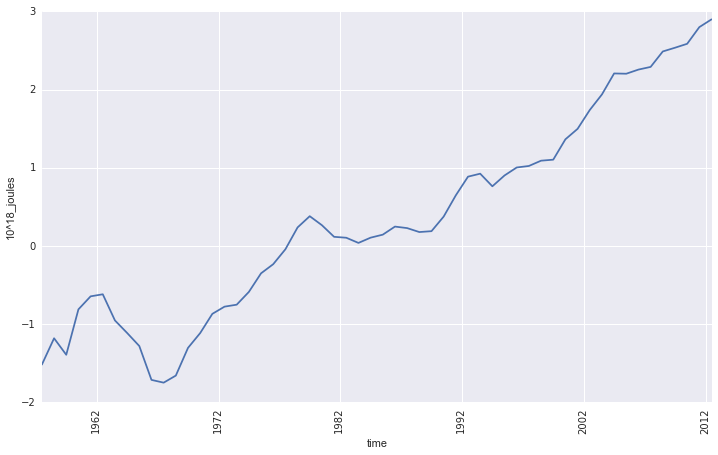

In [192]:
fig, ax = plt.subplots()
hc['h18_hc'].mean(dim=('lon','lat','depth')).plot(ax=ax)
ax.set_ylabel(hc.h18_hc.attrs['units'])

In [50]:
hc.h18_hc

<xray.DataArray 'h18_hc' (time: 56, depth: 1, lat: 180, lon: 360)>
[3628800 values with dtype=float64]
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
  * depth    (depth) int64 0
  * time     (time) datetime64[ns] 1957-07-01T12:00:00 1958-07-01T12:00:00 ...
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
Attributes:
    long_name: Ocean heat content anomaly calculated from objectively analyzed temperature anomaly fields over given depth limits
    cell_methods: area: mean depth: mean time: mean
    grid_mapping: crs
    units: 10^18_joules